# Bengali Fake News Classification
```
    আমি বাংলায় গান গাই
    আমি বাংলার গান গাই।
    আমি আমার আমিকে চিরদিন
    এই বাংলায় খুঁজে পাই।
    
```

# Classify News

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

# Prepare Datasets
- Dataset Info: Datasets contain `48678` authentic news and `1299` fake news. For this experiment, instead of all authentic news, only 5 times of fake news was used.
- And only consider the first 100 words (including headline and content)

- On datasets: Both headline and content of news were used. And manually a separator was added also `[SEP]`.

> BERT model is designed in such a way that the sentence has to start with the [CLS] token and end with the [SEP] token.
If we want to make separation of two sentences we can use [SEP] between sentences

### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [3]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [4]:
auth = pd.read_csv("Authentic-48K.csv")
fake = pd.read_csv("Fake-1K.csv")

df = auth.sample(len(fake)*5)
df = df.append(fake.sample(len(df),replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)


C:\Users\rahat\AppData\Local\Temp\ipykernel_5012\208430676.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fake.sample(len(df),replace=True))


(12990, 48678)

In [5]:
df.head()

,articleID,domain,date,category,headline,content,label
0,1195,channeldhaka.news,2019-02-11T20:26:48+00:00,Lifestyle,ভালোবাসা দিবসে সাশ্রয়ীমূল্যে রুম ভাড়া দিচ্ছে...,আসছে ১৪ই ফেব্রুয়ারী বিশ্ব ভালোবাসা দিবস উপলক্...,0
1,15209,bd-pratidin.com,2018-09-25 08:16:33,National,নিবন্ধন জটিলতায় নতুন দলগুলো,একাদশ সংসদ নির্বাচনের আগে নতুন রাজনৈতিক দলের ন...,1
2,130,earki.com,"সেম্বর ২৮, ২০১৮",Miscellaneous,'জ্বি জ্বি জ্বি জ্বি হুজুর' এখন হয়ে গেলো 'জ্বি...,ভোটের আগ মুহূর্তে সারাদেশে মোবাইল ইন্টারনেট সে...,0
3,987,motikontho.wordpress.com,2013-11-30T15:30:19+00:00,Miscellaneous,সরকার এ দায় এড়াতে পারে না: মতিচুর | দৈনিক মতিকণ্ঠ,নিজস্ব মতিবেদকফরিদপুর জেলার চর আদমপুর গ্রামে ক...,0
4,302,earki.com,"১৫:১০, জানুয়ারি ২৯, ২০১৯",Miscellaneous,বাণিজ্য মেলার মতামত ও অভিযোগ বাক্সে আসলে কী থাকে?,এবারের বাণিজ্য মেলার শুরু হতেই ফেসবুকে একটি মত...,0


In [6]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
একাদশ সংসদ নির্বাচনের আগে নতুন রাজনৈতিক দলের নিবন্ধন নিয়ে জটিলতায় পড়েছে নির্বাচন কমিশন। যথাযথভাবে গঠনতন্ত্র ও প্রয়োজনীয় দলিলাদি না থাকায় অধিকাংশ দলের নিবন্ধন আবেদন নাকচ করে দিলেও দলগুলো আবেদন পুনর্বিবেচনার দাবি জানাচ্ছে। অনেক দল নির্বাচন কমিশনের বিরুদ্ধে আইনি লড়াই করারও হুমকি দিচ্ছে। ইতিমধ্যে বাংলাদেশ জাসদের পুনর্বিবেচনার আবেদন আমলে নিয়েছে নির্বাচন কমিশন। দলটিকে নিবন্ধন দিতে এখন মাঠ পর্যায়ের অফিস ও কমিটি তদন্ত চলছে। তবে বাংলাদেশ জাসদও নিবন্ধন পাবে কি না তা নিশ্চিত করছে না ইসি। বিশ্লেষকদের মতে, সংসদ নির্বাচনের তফসিল ঘোষণার আর মাত্র দেড় মাস বাকি। কিন্তু কমিশন এখনো নতুন দলের নিবন্ধন চূড়ান্ত করতে পারেনি। তবে ভোটের আগে নতুন দলগুলো আইনের আশ্রয় নিলে সংসদ নির্বাচনও হুমকির মুখে পড়তে পারে। এদিকে রাজনৈতিক দল হিসেবে গণসংহতি আন্দোলনের নিবন্ধন আবেদন বাতিলের সিদ্ধান্ত প্রত্যাহার বা পুনর্বিবেচনা করতে নির্বাচন কমিশনকে আইনি নোটিস দিয়েছেন দলটির প্রধান সমন্বয়ক জোনায়েদ সাকী। গণসংহতি আন্দোলনের প্রধান সমন্বয়ক জোনায়েদ সাকীর পক্ষে তার আইনজীবী রবিবার নির্বাচন 

C:\Users\rahat\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [9]:
len(train_df), len(test_df)

(10392, 2598)

In [10]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [11]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

# Define Model
 `Bert` stands for Bidirectional Encoder Representations from Transformers used in this experiment with two additional `Fully Connected` Layers. 
 
 For this experiment, [Bangla Bert](https://huggingface.co/sagorsarker/bangla-bert-base) pretrained model was used.

#### FC layers
- First Linear Layer: IO(768 -> 128)
- Second Linear Layer: IO(128 -> 2)

#### Additionals
- Activation Fuction: Relu
- Dropout: 20%
- Optimizer: AdamW
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [12]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc5(self.dropout(x))
        
        return x

In [13]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# for param in bert.parameters():
#     param.requires_grad = False

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [16]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[ 0.0326, -0.0175]], grad_fn=<AddmmBackward0>)


In [17]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Lets Train

In [18]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [19]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [20]:
epochs = 10
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [21]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.453415.. 	Valid Loss:0.285734.. 	Accuracy: 91.2240
Epoch: 2/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.180216.. 	Valid Loss:0.166235.. 	Accuracy: 95.7275
Epoch: 3/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.069882.. 	Valid Loss:0.134987.. 	Accuracy: 96.9207
Epoch: 4/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.054597.. 	Valid Loss:0.130902.. 	Accuracy: 97.2671
Epoch: 5/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.044339.. 	Valid Loss:0.127536.. 	Accuracy: 97.2671
Epoch: 6/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.047095.. 	Valid Loss:0.124539.. 	Accuracy: 97.2671
Epoch: 7/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.044082.. 	Valid Loss:0.126180.. 	Accuracy: 97.4211
Epoch: 8/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.044930.. 	Valid Loss:0.126708.. 	Accuracy: 97.4211
Epoch: 9/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.046397.. 	Valid Loss:0.126735.. 	Accuracy: 97.4211
Epoch: 10/10


  0%|          | 0/650 [00:00<?, ?it/s]

	Train loss:0.044109.. 	Valid Loss:0.126753.. 	Accuracy: 97.4211
Training completed in 681m 26s


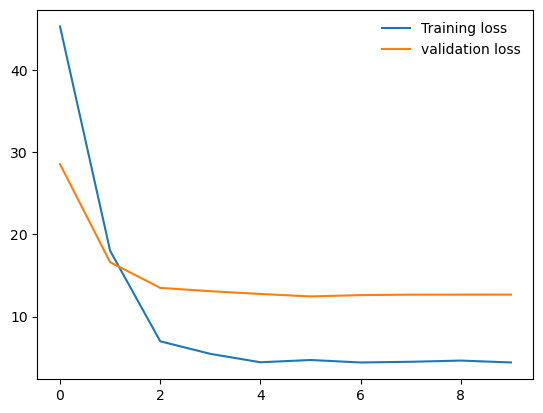

In [22]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [23]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [24]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [25]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1299
           1       0.97      0.97      0.97      1299

    accuracy                           0.97      2598
   macro avg       0.97      0.97      0.97      2598
weighted avg       0.97      0.97      0.97      2598



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।